# Evaluation of spatial feature extraction methods in facial and gesture detection problems

Experiments conducted for the paper. Source: https://github.com/ADA-SITE-JML/gesture_face_features/.

Authors: Ismayil Shahaliyev and Jamaladdin Hasanov.

In [20]:
# !git clone https://github.com/ADA-SITE-JML/gesture_face_features/

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import sys
import os

# modify the project path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, 'src'))

# modify paths accordingly for saving to/loading from
DATA_PATH = os.path.join(PATH, 'samples', 'sign')
FEAT_PATH = os.path.join(PATH, 'out', 'feats')
EMB_PATH  = os.path.join(PATH, 'out', 'embeddings')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# installing libraries for UMAP and MTE

!pip install -q umap-learn # https://umap-learn.readthedocs.io/en/latest/
!git clone -q https://github.com/thuml/Transfer-Learning-Library/

In [25]:
# data setup

from data_folder import SignImageFolder
from torch.utils.data import DataLoader
from torch import cuda

dataset = SignImageFolder(DATA_PATH)
dataloader = DataLoader(dataset, batch_size=16,
                        num_workers=os.cpu_count(),
                        pin_memory=cuda.is_available())
print(f"Count: {len(dataset)}")

Count: 206


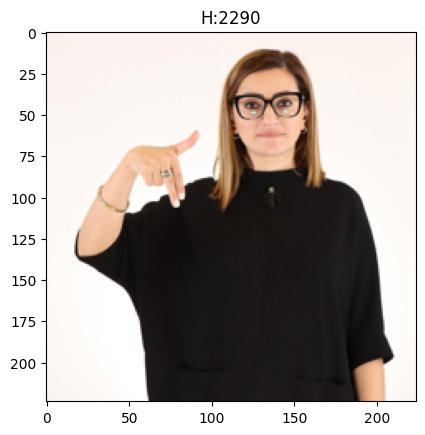

In [26]:
dataset.plot(42)

In [27]:
# extracting feature maps for checkpoint layers
# return nodes and parameters are defined in config.py

from config import MODEL_ZOO, MIN_PARAM_GRID, FULL_PARAM_GRID
from model_loader import ModelLoader
from feature import extract_features

In [28]:
MODEL_ZOO

{'vgg19': {'input_dim': (224, 224),
  'return_nodes': ['features.34', 'features.35', 'avgpool', 'classifier.6']},
 'resnet50': {'input_dim': (224, 224),
  'return_nodes': ['layer4.2.relu_2', 'avgpool', 'fc']},
 'inception_v3': {'input_dim': (299, 299),
  'return_nodes': ['Mixed_7c.branch_pool.conv', 'avgpool', 'fc']},
 'efficientnet_b0': {'input_dim': (224, 224),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']},
 'efficientnet_b1': {'input_dim': (240, 240),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']},
 'efficientnet_b6': {'input_dim': (528, 528),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']}}

In [30]:
'''
  Extracts features for all checkpoint layers
  return_nodes define redundant layers (just in case) which are not used in the experiments
  To speed up the extraction process, use less layers (update MODEL_ZOO)

  FEAT_PATH provides path to save to. Once features are extracted saved to disk,
  they will be loaded through pass very quickly. Contact authors for getting readily extracted features.
'''

feats = {}
for model_name in MODEL_ZOO:
  modelloader = ModelLoader(model_name)
  feats[model_name] = extract_features(dataloader, modelloader, FEAT_PATH)

Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/vgg19_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/resnet50_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/inception_v3_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b0_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b1_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b6_feats.pt.


In [31]:
# getting dummy predictions
from utils import decode_imagenet, predict, delete_keys

for model_name in MODEL_ZOO:
  preds, idx, _ = predict(model_name, feats)
  label_counts, _ = decode_imagenet(idx)
  print(f'Predictions of {model_name}: {label_counts}')

Predictions of vgg19: {'jersey': 67, 'sweatshirt': 62, 'suit': 34, 'military_uniform': 33, 'cardigan': 4, 'wig': 4, 'abaya': 2}
Predictions of resnet50: {'suit': 113, 'wool': 37, 'jersey': 28, 'wig': 25, 'sunglasses': 2, 'safety_pin': 1}
Predictions of inception_v3: {'jersey': 50, 'wool': 45, 'sweatshirt': 35, 'suit': 27, 'wig': 23, 'Band_Aid': 10, 'velvet': 5, 'sunglasses': 4, 'tench': 3, 'maillot': 2, 'abaya': 1, 'bow_tie': 1}
Predictions of efficientnet_b0: {'sweatshirt': 62, 'suit': 34, 'military_uniform': 34, 'abaya': 32, 'wig': 30, 'jersey': 11, 'wool': 3}
Predictions of efficientnet_b1: {'jersey': 40, 'sweatshirt': 37, 'wool': 37, 'suit': 34, 'abaya': 29, 'necklace': 23, 'perfume': 3, 'sunglasses': 2, 'wig': 1}
Predictions of efficientnet_b6: {'sweatshirt': 66, 'jersey': 38, 'wool': 37, 'suit': 28, 'cardigan': 18, 'wig': 18, 'abaya': 1}


In [32]:
### Data Partitioning (Section 3.1.1) ###

from participant import filter_participants, filter_targets

# Set partition to False for experimenting with all features on a single partition
partition = True

if partition:
  parts = filter_participants(feats, dataset)
  targets = filter_targets(dataset)

In [12]:
### Initial MTE Ranking (Section 3.3) ###

%cd Transfer-Learning-Library

from mte import get_mte_scores

for i in range(len(parts)):
  print(f'-----Participant {i}-----')
  get_mte_scores(parts[i], targets[i])

/content/Transfer-Learning-Library
-----Participant 0-----
Calculating scores for vgg19...
Calculating scores for resnet50...
Calculating scores for inception_v3...
Calculating scores for efficientnet_b0...
Calculating scores for efficientnet_b1...
Calculating scores for efficientnet_b6...

=== Ranked Models by LEEP ===
Rank  Model                Score          
---------------------------------------------
1     efficientnet_b6      -1.918715
2     efficientnet_b0      -1.927447
3     vgg19                -1.931031
4     efficientnet_b1      -1.931654
5     inception_v3         -1.935066
6     resnet50             -1.941351


=== Ranked Models by LogME ===
Rank  Model                Score          
---------------------------------------------
1     efficientnet_b6      -0.359512
2     efficientnet_b0      -0.383698
3     resnet50             -0.397275
4     inception_v3         -0.412222
5     efficientnet_b1      -0.418294
6     vgg19                -0.443938


=== Ranked Models by 

In [34]:
# Extracted layers
for model in MODEL_ZOO:
  print(parts[0][model].keys())

dict_keys(['features.34', 'features.35', 'features.36', 'avgpool', 'classifier.6'])
dict_keys(['layer4.2.conv3', 'layer4.2.relu_2', 'avgpool', 'fc'])
dict_keys(['Mixed_7c.branch_pool.conv', 'avgpool', 'fc'])
dict_keys(['features.8', 'avgpool', 'classifier.1'])
dict_keys(['features.8', 'avgpool', 'classifier.1'])
dict_keys(['features.8', 'avgpool', 'classifier.1'])


In [35]:
# Removing unncessary layers not used in the further experiments (3.5.1)

N = len(parts)

for i in range(N):
  for model_name in parts[i]:
    delete_keys(parts[i][model_name], key_list=[
      'classifier.1', 'classifier.6','fc',
      'features.34', 'features.36', 'layer4.2.conv3'
    ])

In [36]:
# should return last convolutional and GAP layers
# (except for vgg19, which is not GAP, even if called avgpool - see config.py notes)
for model in MODEL_ZOO:
  print(parts[0][model].keys())

dict_keys(['features.35', 'avgpool'])
dict_keys(['layer4.2.relu_2', 'avgpool'])
dict_keys(['Mixed_7c.branch_pool.conv', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])


In [37]:
### Main Experiments ###

from engines.reducer import Reducer, ReducerEngine
from engines.embedding import Embedding, EmbeddingEngine
from engines.cluster import Cluster, ClusterEngine

# Random state wasn't used in the initial experiments in order to keep variability of results.
# The experiments will return similar outcomes independent of the RANDOM_STATE value

RANDOM_STATE = 42

In [38]:
### Dimensionality Reduction (Section 3.5.2) ###

r = Reducer(parts[0], targets[0], 'resnet50', 'avgpool', 'umap', random_state=RANDOM_STATE)
r.get_embedding(params={'n_neighbors': 10,'min_dist': 0.3,'metric': 'euclidean'})
r.embedding

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 7.2575874, 17.821451 ],
       [ 6.736015 , 18.857914 ],
       [ 6.9413095, 18.321154 ],
       [ 8.527893 , 14.216325 ],
       [ 8.209682 , 13.620561 ],
       [ 8.20389  , 14.160456 ],
       [ 6.6109304, 16.646685 ],
       [ 8.1699295, 14.875522 ],
       [ 7.5215507, 14.600852 ],
       [ 5.562185 , 16.78135  ],
       [ 8.116776 , 15.609563 ],
       [ 5.989176 , 16.48315  ],
       [ 7.69527  , 15.332857 ],
       [ 6.0152087, 16.064627 ],
       [ 8.619811 , 14.762594 ],
       [ 5.647985 , 17.285141 ],
       [ 5.9963565, 20.099365 ],
       [ 7.5187416, 15.942788 ],
       [ 7.500817 , 16.919357 ],
       [ 6.7045217, 15.039201 ],
       [ 5.479563 , 19.54473  ],
       [ 6.5565295, 19.804998 ],
       [ 6.70312  , 14.101069 ],
       [ 6.4379063, 19.292448 ],
       [ 7.2197127, 13.821501 ],
       [ 6.4496355, 14.326124 ],
       [ 6.136316 , 17.566181 ],
       [ 6.350311 , 18.43432  ],
       [ 7.7581024, 14.335703 ],
       [ 7.1724787, 15.512666 ],
       [ 6

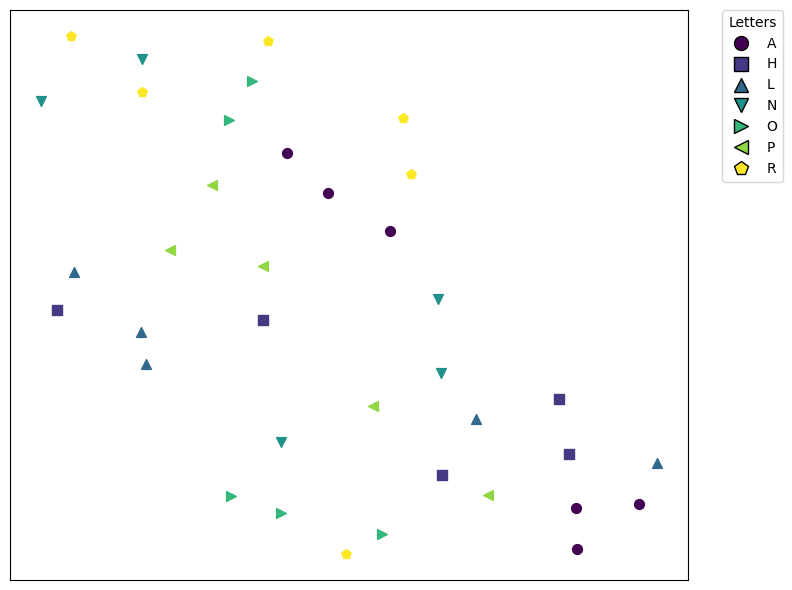

In [39]:
# random embedding has weak clustering
r.plot(dataset.idx_to_class)

In [41]:
### Clustering (Section 3.5.3) ###

# n_cluster = 7 for having 7 distinct signs

e = Embedding(r, 'kmeans', n_clusters=7, random_state=RANDOM_STATE)
e.get_clusters()
e.cluster

array([3, 3, 3, 2, 2, 2, 0, 5, 5, 0, 6, 0, 6, 0, 2, 0, 1, 6, 6, 5, 1, 1,
       4, 1, 4, 4, 3, 3, 5, 6, 3, 1, 1, 4, 1, 1, 3], dtype=int32)

In [44]:
### Scoring (Section 3.5.4) ###

c = Cluster(e)
c

-------resnet50 avgpool-------

Cluster 3: ['A', 'A', 'A', 'P', 'P', 'P', 'R']
Cluster 2: ['A', 'A', 'A', 'L']
Cluster 0: ['H', 'H', 'L', 'L', 'L']
Cluster 5: ['H', 'H', 'N', 'P']
Cluster 6: ['H', 'L', 'N', 'N', 'P']
Cluster 1: ['N', 'N', 'O', 'O', 'R', 'R', 'R', 'R']
Cluster 4: ['O', 'O', 'O', 'R']

Purity: 0.54
Custom Weighted Score: 0.55

In [45]:
# use FULL_PARAM_GRID for the set of parameters noted in the paper

MIN_PARAM_GRID
# FULL_PARAM_GRID

{'umap': {'n_neighbors': [5, 15, 30],
  'min_dist': [0.01, 0.1, 0.3],
  'metric': ['euclidean']},
 'tsne': {'perplexity': [10, 15, 25],
  'learning_rate': [100],
  'metric': ['euclidean']},
 'pca': {'whiten': [False], 'svd_solver': ['full']}}

In [46]:
### Engine for extracting all embeddings ###

# Don't use random state for achieving parallelism

res = [{method: None for method in MIN_PARAM_GRID} for _ in range(N)]

for i in range(6):
  print(f'\n------- Participant {i}---------')
  emb_path = os.path.join(EMB_PATH, str(i))

  for method in MIN_PARAM_GRID:
    re = ReducerEngine(
      parts[i],
      targets[i],
      method=method,
      param_grids=MIN_PARAM_GRID,
      n_components=2,
      random_state=RANDOM_STATE,
      emb_path=emb_path,
    )
    re.get_all_embeddings(from_disk=True)
    res[i][method] = re


------- Participant 0---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_solver': ['full']}.

------- Participant 1---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_solver': ['full']}.

------- Participant 2---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_sol

In [47]:
### Engine for generating and scoring all clusters ###

from mte import get_nleep_score

ees = [{} for _ in range(N)]
ces = [{} for _ in range(N)]

for i, re in enumerate(res):
  print(f'-----Participant {i}-----')
  for method in MIN_PARAM_GRID:
    print(method)
    for model in ['kmeans', 'gmm']:
      ee = EmbeddingEngine(re[method], model, n_clusters=7, random_state=RANDOM_STATE)
      ee.get_all_clusters()
      ce = ClusterEngine(ee)
      ce.score_all_clusters()
      for cluster in ce.scored_clusters:
        get_nleep_score(cluster, random_state=RANDOM_STATE, verbose=False)
      ees[i][(method, model)] = ee
      ces[i][(method, model)] = ce

-----Participant 0-----
umap
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
tsne
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
pca
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
-----Participant 1-----
umap
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
tsne
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
pca
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
-----Participant 2-----
umap
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
tsne
Getting kmeans clusters...
Getting cluster scores...
Getting gmm clusters...
Getting cluster scores...
pca
Getting kmeans clusters...
Getting cluster scores...
Getting g

In [51]:
### Ranking & Results (Secion 3.6) ###

from rank import rank_clusters, plot_ranking

# Change values for plotting needed subset
# Participant 5 UMAP + GMM returned the top result which can be easily verified

part   = 5
method = ['pca','umap','tsne'][1]
model  = ['kmeans','gmm'][1]
metric = ['custom','nleep'][0]

ce = ces[part][(method, model)]
scored_clusters = ce.scored_clusters
ranked_clusters = rank_clusters(scored_clusters, metric=metric)
df = plot_ranking(scored_clusters, ranked_clusters,  metric=metric)
df

,model,layer,params,custom,mean
0,efficientnet_b0,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.94,0.79
1,efficientnet_b6,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.93,0.79
2,efficientnet_b1,avgpool,"{'metric': 'euclidean', 'min_dist': 0.1, 'n_ne...",0.91,0.70
3,resnet50,avgpool,"{'metric': 'euclidean', 'min_dist': 0.3, 'n_ne...",0.89,0.74
4,inception_v3,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.84,0.75
5,vgg19,features.35,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.77,0.68


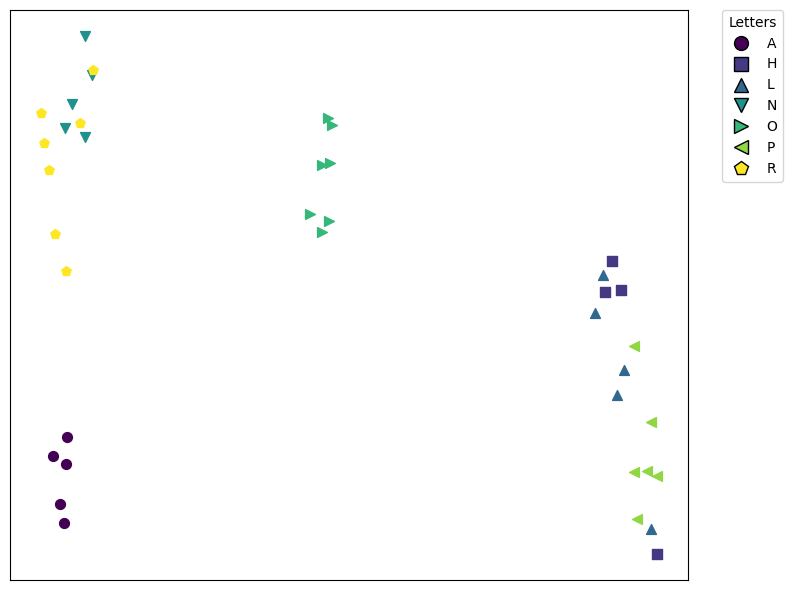

In [52]:
ces[part][(method,model)].best_cluster.embedding.reducer.plot(dataset.idx_to_class)

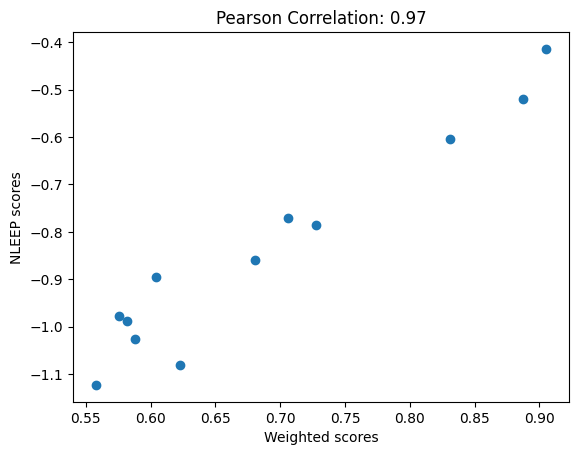

In [54]:
### NLEEP correlation (Section 3.6.1) ###

import numpy as np
import matplotlib.pyplot as plt

nleep_scores = [cluster.nleep_score for cluster in ce.scored_clusters]
scores = [cluster.score for cluster in ce.scored_clusters]
corr = np.corrcoef(scores, nleep_scores)[0, 1]

plt.scatter(scores, nleep_scores)
plt.xlabel('Weighted scores')
plt.ylabel('NLEEP scores')
plt.title(f'Pearson Correlation: {corr:.2}');

In [53]:
### Aggregate Ranking (Section 3.6.2) ###

# Ranking done for the MIN_PARAM_GRID
# Use FULL_PARAM_GRID for aligning further with the paper

import pandas as pd

columns = list(range(N)) + ['Total']
counts_df = pd.DataFrame(0, index=MODEL_ZOO, columns=columns)

for i in range(N):
  for method in MIN_PARAM_GRID:
    for model in ['kmeans','gmm']:
      ce = ces[i][(method, model)]
      scored_clusters = ce.scored_clusters
      ranked_clusters = rank_clusters(scored_clusters,  metric=metric)
      for cluster in ranked_clusters[:1]:  # top_n = 1
        model_name = cluster.embedding.reducer.model_name
        if model_name in counts_df.index:
          counts_df.at[model_name, i] += 1

counts_df['Total'] = counts_df[list(range(N))].sum(axis=1)
counts_df = counts_df.sort_values(by='Total', ascending=False)

counts_df

,0,1,2,3,4,5,Total
resnet50,5,2,0,1,0,2,10
efficientnet_b6,0,3,3,0,2,0,8
efficientnet_b0,0,0,0,3,0,4,7
inception_v3,1,1,2,2,0,0,6
efficientnet_b1,0,0,1,0,4,0,5
vgg19,0,0,0,0,0,0,0
